## Gaussian Mixture Models for TIMIT

+ ###### Authors: Dirk Van Compernolle
+ ###### History:  04/2022, 17/03/2023, 05/03/2024
+ ###### Requires: pyspch v0.7 / 0.8  

Content:
- Training of GMMs for all phonemes
- Frame CLassification
- Applying the models for utterance analysis


In [1]:
####################################################################################
### RUNNING THIS CELL FIRST ##########
### will suppresses warnings on memory leaks, deprecation warnings and future warnings 
### It is brute force .  
### Best is not to run it when you want to debug code or new installations
import os, warnings 
os.environ["OMP_NUM_THREADS"] = '2'  
warnings.filterwarnings("ignore")
####################################################################################

In [2]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [3]:
%matplotlib inline
import io, os, sys
import logging

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import requests
import importlib
import urllib.request
import pickle
import gzip

from sklearn import metrics as skmetrics 
from sklearn.neural_network import MLPClassifier
from IPython.display import display, HTML, Audio

# reproducibility 
torch.manual_seed(0) 
np.random.seed(0)
logging.basicConfig(level=logging.INFO)

# print and plot
mpl.rcParams['figure.figsize'] = [7.,7.]
mpl.rcParams['font.size'] = 11
np.set_printoptions(precision=3)
cmap_jet2 = sns.mpl_palette("jet",60)[5:55]

# pyspch
import pyspch
from pyspch.stats import GMM
import pyspch.core as Spch

# device
use_cuda_if_available = True
if use_cuda_if_available:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
else:
    device = "cpu"

## Functions and Utilities
 
Data Utilities:   
+ get_timit_data() reads processed features from the server   
+ downsample_data_sets() downsamples the database (for speedup purposes)   
+ print_dataset_statistics()   

GMM Utilities:   
- train_GMM(): trains a GMM model   
- test_GMM():  tests a GMM model (returns global result and confusion matrix)
- train_MLP(): trains a MLP
- test_clf():  tests a sklearn type classifier


In [4]:
# TIMIT Utilities: getting processed data from server, down sampling the database, statistics
#
def get_timit_data(corpus="train",ftrs="mfcc13",alphabet="timit41",
                 root='https://homes.esat.kuleuven.be/~spchlab/data/timit/'):
    '''
    get processed TIMIT data (part of it) from the server
    
    corpus         should be "train" or "test"
                    or supplemented with  "", "_mini", "_dr1" ,"_si1"  for full, mini(10%), single subdirectory dr1, only 1 SI sentence (=10%)
    ftrs:          type of preprocessed features (mfcc13, mel24 or mel80)
    alphabet:      choice of alphabet to use  (TIMIT61 should be convertable to it)
    '''
    
    corpus_file = root + "conf/timit_" + corpus + ".corpus"
    corpus_data = pyspch.read_txt(corpus_file)
    
    # pickled files of features are available for 'master' corpus only
    # subcorpus selection happens later
    master_corpus = corpus.split("_",1)[0]   # 
    pickle_file = root + "features/" + ftrs + "/" + master_corpus + ".pkl"
    ftrs_df = pd.read_pickle(pickle_file)
    data = pyspch.core.DataFrame_to_SpchData(ftrs_df, delete_df=True) 
    data = data.subset(corpus_data) 
    
    # map originial TIMIT 61 transcriptions to the chosen alphabet
    lab2classes = pyspch.timit.get_timit_mapping('timit61'+'_'+alphabet) 
    data.modify_labels(lab2classes) # timit61 -> timit41    
    return(data)

def get_selection(y,labels=None,downsample=1,mincount=1):
    '''
    finds selection of labels in y and downsamples them but capped to mincount
    '''
    
    if labels is None:
        labels = np.unique(y)
    indx = np.full(len(y),False,dtype='bool')
    
    for lbl in labels:
        selection = (y==lbl)
        n = sum(selection)
        #print(n,selection)
        ds = min(downsample, max(1,n//mincount) ) # ds is downsample for lbl
        A = np.where(selection)[0]
        indx[A[::ds]]=True    
    return(indx)


def downsample_data_sets(X_in,y_in,downsample=1,mincount=64):
    '''
    downsample an existing dataset (X,y)
    '''
    #print(X_in.shape,y_in.shape)
    dim = X_in.shape[1]
    X = np.empty((0,dim),'float64')
    y = np.empty((0,),dtype='<U3')
    labels = np.unique(y_in)
    #print(labels)
    for lbl in labels:
        selection = (y_in==lbl)
        n = sum(selection)
        ds = min(downsample, max(1,n//mincount) )
        #print(lbl,n,ds)
        X = np.vstack((X,X_in[selection][::ds]))
        y = np.concatenate((y,y_in[selection][::ds]))
    return(X,y)

def print_dataset_statistics(y,Details=False,txt="dataset"):
    '''
    print global dataset statistics
    if Details=True, you also get statistics per label
    '''
    labels = np.unique(y)
    print("Statistics for %s:" % txt)
    print("Number of classes",len(labels))
    print("Number of samples",len(y)) 
    samples_per_class = [ sum(y==lbl) for lbl in labels ]
    print("Minimun/Maximum number of samples per class: ",np.min(samples_per_class), ' / ',np.max(samples_per_class))
    if(Details):
        print([ (labels[i],samples_per_class[i]) for i in range(len(labels)) ] )

In [5]:

######   Classifier Utilities   #######################################
def train_GMM(X_train,y_train,classes=None,n_components=1,max_iter=10,Verbose=False,**kw_args):
    clf = GMM(classes=classes,n_components=n_components,max_iter=max_iter,**kw_args)                  
    clf.fit(X_train,y_train)
    ll, bic = clf.ll_and_bic(X_train,y_train)
    y_pred = clf.predict(X_train)
    acc_train = 100.0*skmetrics.accuracy_score(y_train, y_pred)
    if Verbose:
        print('Training Set:  Accuracy = %.2f%%' % (acc_train) )
        print('Training Set:  LL(per sample) = %.2f' % (ll) )
        print('Training Set:  BIC = %.2f' % (bic) )
    return(clf,acc_train) #,ll,bic))    


def train_MLP(X_train,y_train,classes=None,
              learning_rate=0.005,hidden_layer_sizes=(256,),max_iter=500, early_stopping=True):               
    clf = MLPClassifier(solver='adam', 
                                    learning_rate_init=learning_rate_init,
                                    hidden_layer_sizes=hidden_layer_sizes,
                                    max_iter=max_iter, 
                                    early_stopping=early_stopping,
                                    alpha=1e-5, random_state=1, validation_fraction=0.1)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_train)
    acc_train = 100.0*skmetrics.accuracy_score(y_train, y_pred)
    if Verbose:
        print('Training Set:  Accuracy = %.2f%%' % (acc_train) )
    return(clf,acc_train)    


def test_GMM(clf_GMM,X_test,y_test,priors=None,norm=False,Verbose=False):
    try:
        if priors == 'uniform':
            priors = [1]*clf_GMM.n_classes
        elif priors == 'training':
            priors = None
    except:
        pass
    y_pred = clf_GMM.predict(X_test,priors=priors)
    acc_test = 100.0*skmetrics.accuracy_score(y_test, y_pred) 
    conf_mat = skmetrics.confusion_matrix(y_test,y_pred,labels=clf_GMM.classes)
    if Verbose:
        print('Test Set:      Accuracy = %.2f%%'  % (acc_test) )
        xx =  clf_GMM.n_classes/4. 
        Spch.plot_confusion_matrix(conf_mat,labels=clf_GMM.classes,norm=norm,figsize=(xx+3,xx+3),annot_kws={'fontsize':8})
    return(acc_test,conf_mat)

def test_clf(clf,X_test,y_test,priors=None,norm=False,Verbose=False):
    try: # if classifier supports usage of priors
        if priors == 'uniform':
            priors = [1]*clf.n_classes
        elif priors == 'training':
            priors = None
        y_pred = clf.predict(X_test,priors=priors)
    except:
        y_pred = clf.predict(X_test)

    try:
        classes = clf.classes
    except:
        classes = clf.classes_
    n_classes = len(classes)
    
    acc_test = 100.0*skmetrics.accuracy_score(y_test, y_pred) 
    conf_mat = skmetrics.confusion_matrix(y_test,y_pred,labels=classes)
    if Verbose:
        print('Test Set:      Accuracy = %.2f%%'  % (acc_test) )
        xx =  n_classes/4. 
        Spch.plot_confusion_matrix(conf_mat,labels=clf_GMM.classes,norm=norm,figsize=(xx+3,xx+3),annot_kws={'fontsize':8})
    return(acc_test,conf_mat)

### Get TIMIT Data and do Feature Extraction

##### TIMIT database
In the next cell we load preprocessed features for the TIMT database
We structure them as a long list of feature vectors with a synchronized list of classes.
The targets (classes) are 41 phonetic symbols, i.e. the CMU-39 set + silence + closure.    
The phonetic labels are obtained from hand labels available with the TIMIT database.

##### Feature Extraction
Three types of features are available on disk:   
- MFCC13: mel frequency cepstral coefficients   
- MEL24:  mel filterbank (low resolution)   
- MEL80:  mel filterbank   

We add 2 further processing steps:   
- addition of Delta features (+13 -> 26)   
- mean and variance normalization per sentence (26)

##### Downsampling and data selection
For the simple experiments we run here it is OK to speed up things (and still get viable) results by downsampling the full database with a factor 10.  At the same time we are setting a count threshold on each class, e.g. of 256 !!   
For some experiments we also select a subset of phonemes for our evaluation.
This is all implemented via the get_selection() module that finds the necessary indices in the database

## Database Statistics 

### For the FULL TIMIT TRAIN Database

Number of classes 41   
Number of samples 1417087   
Minimun number of samples per class:  226266   
Maximum number of samples per class:  1218 

You will note that the data distribution is heavily skewed.
This is normal as some phonemes are way more frequent than others.  
Moreover the average length of a phoneme plays a role as we take each frame as an observation and just look for the corresponding label in the TIMIT transcriptions.
Some phonemes thus have thousands of examples available for training, while others (e.g. 'zh') are only marginally represented, e.g.
> ('aa', 37481)   
> ('sil', 226626)   
> ('t', 28720)  
> ('zh', 1218)      

The biggest class is 'sil' with 200k+ samples, the biggest phone classes are 's' and 'ih' with 80k+ samples.  The smallest classes are 'b', 'uh' and 'zh' with less than 5000 samples each



In [76]:
alphabet = 'timit41'
classes_timit = pyspch.timit.get_timit_alphabet('timit41')
ftrs = "mel24"  # "mfcc13"
modify_feature_args = {"Norm":"meanvar","Deltas":"delta"}
data = get_timit_data(corpus="train",ftrs=ftrs,alphabet=alphabet)
data.modify_features(modify_feature_args)
X_timit_train = data.get_features_as_numpy() 
y_timit_train = data.get_labels_as_numpy()
data = get_timit_data(corpus="test",ftrs=ftrs,alphabet=alphabet)
data.modify_features(modify_feature_args)
X_timit_test = data.get_features_as_numpy() 
y_timit_test = data.get_labels_as_numpy()

In [77]:
print_dataset_statistics(y_timit_train,Details=True,txt="Full Train Database")
print_dataset_statistics(y_timit_test,Details=True,txt="Full Test Database")

Statistics for Full Train Database:
Number of classes 41
Number of samples 1417087
Minimun/Maximum number of samples per class:  1218  /  226626
[('aa', 37481), ('ae', 59237), ('ah', 39140), ('ao', 36404), ('aw', 11723), ('ay', 34376), ('b', 3823), ('ch', 7116), ('cl', 137933), ('d', 8158), ('dh', 10640), ('eh', 35133), ('er', 51761), ('ey', 28955), ('f', 22828), ('g', 6031), ('hh', 14142), ('ih', 84270), ('iy', 62901), ('jh', 7063), ('k', 25064), ('l', 43515), ('m', 24859), ('n', 46996), ('ng', 8513), ('ow', 26853), ('oy', 11024), ('p', 11482), ('r', 39609), ('s', 84491), ('sh', 25828), ('sil', 226626), ('t', 28720), ('th', 6862), ('uh', 4077), ('uw', 26444), ('v', 12033), ('w', 20946), ('y', 11322), ('z', 31490), ('zh', 1218)]
Statistics for Full Test Database:
Number of classes 41
Number of samples 517845
Minimun/Maximum number of samples per class:  643  /  81852
[('aa', 14133), ('ae', 21072), ('ah', 14948), ('ao', 14233), ('aw', 3751), ('ay', 12613), ('b', 1562), ('ch', 2244), ('c

## Exercise 1:  Use the vow6-database

In this experiment we perform vowel recognition from frame data.   
The experiment is easy in the sense that the used vowels are rather well distinguishable.   
The experiment is hard because you base your prediction on a single frame positioned well inside but also at the boundaries of a vowel. 

We have entered quite reasonable default values in the next cell:
- use of static and dynamic MFCCs (26D)
- 8 mixtures in the GMM per class
- 2 iterations for the GMM training (the KMeans initialization routine does almost all the work, so little will be gained from iterating)
- priors are used as derived from the training set (set the priors variable to 'training' or 'uniform')
- with these default settings you should achieve (approximately) a train set accuracy of 68% and a test set accuracy of 67%

Things to explore:
1. What changes do you observe if you change the priors from 'training' (i.e. the priors as observed during training) to 'uniform'; which phonemes are better recognized ? Could you have predicted this from the vow6-database statistics as printed above ?

2. Explore with different subsets of the MFCC features set (which contains 13 static MFCCs and 13 dynamic coefficients)  and rate the corresponding statement with True or False (and explain)
    - slice(13,26) selects the delta featurs
        + "just using delta features will give me no better result than chance because we are doing vowel recognition and vowels are statianory, so all delta's will be close to zero"
    - slice(0,13) selects the static MFCC-13
        + "my result will be somewhat worse than with MFCC-26. Probably frames that are in the middle of a phone get equally well recognized, however, frames at phone boundaries can benefit from the inclusion of delta and delta-delta information.  If I would go back to the original segmentation and make a note of where a frame was situated in a phone, then I could test this."

3. Vary the number of components between 1 ,... 8, ... 64. Again rate the statements as True or False.
    - I'm getting the best result on my test set with 8 components.  So I will use this in all future systems that I am building.
    - I'm getting the best the result on the train set when using 64 components. Just bad luck that the train set didn't like this model as much.
    - When looking at my training database size, I could have predicted that results for number of components larger than 16 are bound to be miserable.
    - "For one particular setting I got a higher accuracy on test set than on training set.  I didn't believe it and threw the result away"

In [78]:
classes= classes_timit
vow6=['iy','aa','uw','ih','eh','er']
plosives=['p','t','k','b','d','g']
classes=vow6

downsample = 10
mincount = 256
indx_train = get_selection(y_timit_train,labels=classes,
                           downsample=downsample,mincount=mincount)
indx_test = get_selection(y_timit_test,labels=classes,
                           downsample=downsample,mincount=mincount)
y_train = y_timit_train[indx_train]
X_train = X_timit_train[indx_train]
y_test = y_timit_test[indx_test]
X_test = X_timit_test[indx_test]
ftr_dim = X_train.shape[1]

print_dataset_statistics(y_train,Details=True)
print_dataset_statistics(y_test,Details=True)

Statistics for dataset:
Number of classes 6
Number of samples 29803
Minimun/Maximum number of samples per class:  2645  /  8427
[('aa', 3749), ('eh', 3514), ('er', 5177), ('ih', 8427), ('iy', 6291), ('uw', 2645)]
Statistics for dataset:
Number of classes 6
Number of samples 10884
Minimun/Maximum number of samples per class:  797  /  2882
[('aa', 1414), ('eh', 1280), ('er', 2114), ('ih', 2882), ('iy', 2397), ('uw', 797)]


Training Set:  Accuracy = 60.08%
Training Set:  LL(per sample) = -29.39
Training Set:  BIC = 1799576.61
Test Set:      Accuracy = 60.15%


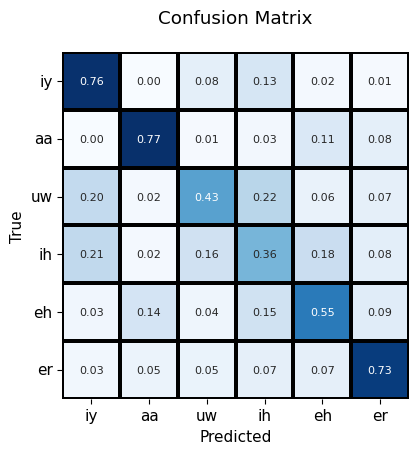

In [79]:
# Train a baseline single Gaussian model
priors = 'training'
n_components = 8
max_iter = 4
kwargs =dict(verbose=0,verbose_interval=1,init_params='kmeans')    
clf_GMM,_ = train_GMM(X_train, y_train,  classes=classes, n_components=n_components, max_iter=max_iter,Verbose=True,**kwargs)
acc_test,cm = test_GMM(clf_GMM, X_test, y_test,  Verbose=True, norm=True, priors=priors)

Training Set:  Accuracy = 62.91%
Training Set:  LL(per sample) = -33.85
Training Set:  BIC = 2021108.65
Test Set:      Accuracy = 63.22%


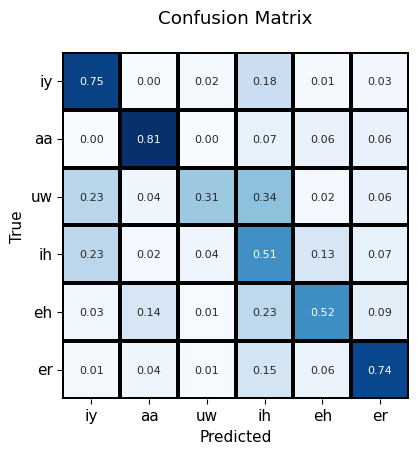

In [40]:
#######################
# modify one of the next four lines to do the requested experiments
feature_selection = slice(0,26)       # default: slice(0,26)       
n_components = 1                  # default: 8
max_iter = 8                       # default: 8
priors =  'training'                  # default: 'training'  (alternative: 'uniform')
######################
# you can also modify other training settings by using this **kwargs{}
#  kwargs = dict(verbose=2,verbose_interval=1)   will print loglik-change (per sample) per iteration
#  kwargs = dict(init_params='random')           will change initialization to random instead of KMeans  (more convergence effort is needed)
#  kwargs = dict(reg_cover=1.e-6,tol=1.e-3)      are some other parameters controlling regularization and a stopping criterion for training
#
kwargs =dict(verbose=0,verbose_interval=1,init_params='kmeans')          
################
# train the model
clf_GMM,_ = train_GMM(X_train[:,feature_selection], y_train,  classes=vow6,
                    n_components=n_components, max_iter=max_iter,Verbose=True,**kwargs)
# test the model
acc_test,cm = test_GMM(clf_GMM, X_test[:,feature_selection], y_test,  Verbose=True, norm=True, priors=priors)

### Performce in function of number of cepstral coefficients
You can add or omit the delta's    
You can run the next cell after the "VOW6" experiment or after the "ALL PHONEMES" experiment

In [82]:
# Effect of feature Vector Size
n_components = 4                 # default: 8
max_iter = 8                     # default: 
priors =  'training'              # default: 'training'  (alternative: 'uniform')
ADD_DELTAS = True
kwargs =dict(verbose=0,verbose_interval=1,init_params='kmeans')  
dim = ftr_dim = X_train.shape[1]//2   # assuming that you added delta's initially

indx=[]
results = []
for nftrs in range(1,dim):
    indx.append(nftrs)
    if ADD_DELTAS:
        ftr_range = np.r_[0:nftrs,dim:dim+nftrs]
    else:
        ftr_range = np.r_[0:nftrs]
    #print("FEATURE SELECTION: %d " % nftrs)
    X_train_sel = X_train[:,ftr_range]
    X_test_sel = X_test[:,ftr_range]

    # train the model
    clf_GMM,_ = train_GMM(X_train_sel, y_train,  classes=classes,
                    n_components=n_components, max_iter=max_iter,Verbose=False,**kwargs)
    # test the model
    acc_train,_ = test_GMM(clf_GMM, X_train_sel, y_train,  Verbose=False, norm=True, priors=priors)
    acc_test,_ = test_GMM(clf_GMM, X_test_sel, y_test,  Verbose=False, norm=True, priors=priors)
    #print('Test Set:      Accuracy = %.2f%%'  % (acc_test) )
    results.append([acc_train,acc_test])

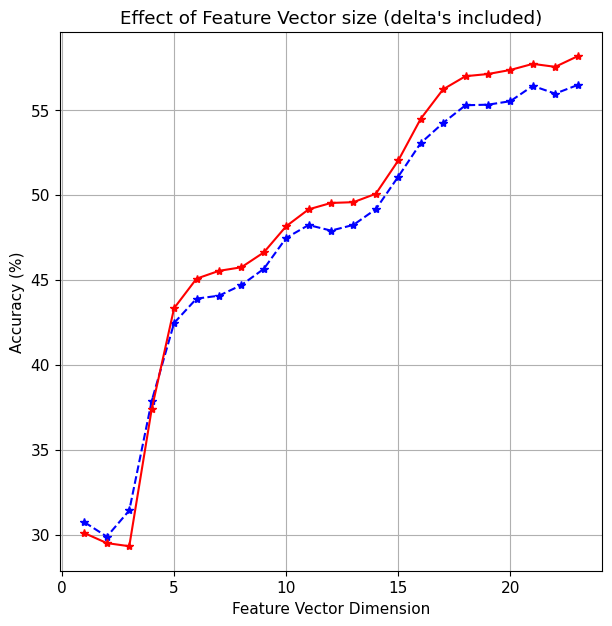

In [83]:
results_ar = np.array(results)
fig,ax = plt.subplots(figsize=(7,7))
ax.plot(indx,results_ar[:,0],"*--",color='b')
ax.plot(indx,results_ar[:,1],"*-",color='r')
ax.grid()

if(ADD_DELTAS):
    title = "Effect of Feature Vector size (delta's included)"
    #plt.savefig("ncep_c+d")
else:
    title = "Effect of Feature Vector size (without delta's)"
    #plt.savefig("ncep_c")
ax.set_title(title)
ax.set_xlabel("Feature Vector Dimension")
ax.set_ylabel("Accuracy (%)");

In [74]:
# Effect of Training datasize
n_components = 1                 # default: 8
max_iter = 4                     # default: 4
priors =  'training'              # default: 'training'  (alternative: 'uniform')
ADD_DELTAS = False
kwargs =dict(verbose=0,verbose_interval=1,init_params='kmeans')  

indx = []
results = []
for ix in [1,2,5,10,20,50,100]:
    indx.append(100./ix)
    if ADD_DELTAS:
        ftr_range = np.r_[0:nftrs,13:13+nftrs]
    else:
        ftr_range = np.r_[0:nftrs]
    #print("FEATURE SELECTION: %d " % nftrs)
    X_train_sel = X_train[::ix,ftr_range]
    y_train_sel = y_train[::ix]
    X_test_sel = X_test[:,ftr_range]

    # train the model
    clf_GMM,_ = train_GMM(X_train_sel, y_train_sel,  classes=classes,
                    n_components=n_components, max_iter=max_iter,Verbose=False,**kwargs)
    # test the model
    acc_test,cm = test_GMM(clf_GMM, X_test_sel, y_test,  Verbose=False, norm=True, priors=priors)
    #print('Test Set:      Accuracy = %.2f%%'  % (acc_test) )
    results.append(acc_test)

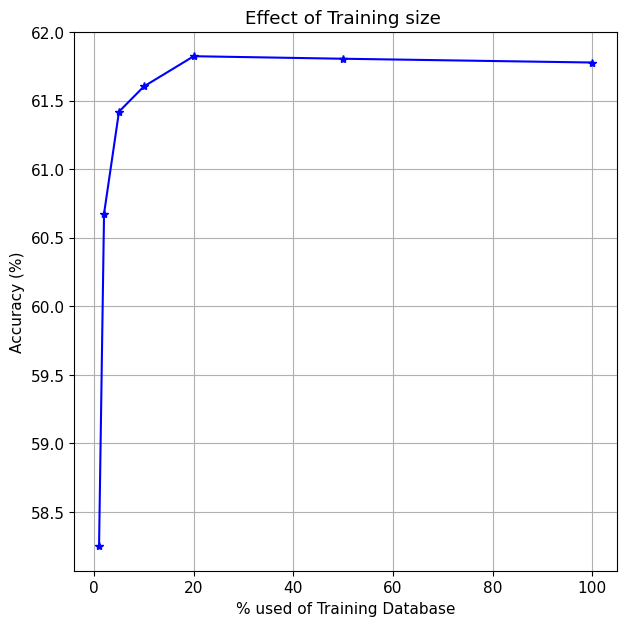

In [75]:
plt.figure(figsize=(7,7))
plt.plot(indx,results,"*-")
plt.grid()
plt.xlabel("% used of Training Database")
plt.ylabel("Accuracy (%)")
if(ADD_DELTAS):
    plt.title("Effect of Training size ");
    #plt.savefig("training_size_c+d")
else:
    plt.title("Effect of Training size ");
    #plt.savefig("training_size_c")

### Exercise 2: Training with all phonemes

We are now doing similar experiments with all phonemes.
We have precomputed training/test results for variable feature sets (MFCC13 or MFCC13+Delta's) and variable number of Gaussians.
The results given below were obtained using 10% of the TIMIT data.
Small random deviations in performance results are possible due to hardware, random number initializations, ... 


In [32]:
classes= classes_timit
downsample = 10
mincount = 256
indx_train = get_selection(y_timit_train,labels=classes,
                           downsample=downsample,mincount=mincount)
indx_test = get_selection(y_timit_test,labels=classes,
                           downsample=downsample,mincount=mincount)
y_train = y_timit_train[indx_train]
X_train = X_timit_train[indx_train]
y_test = y_timit_test[indx_test]
X_test = X_timit_test[indx_test]
ftr_dim = X_train.shape[1]

print_dataset_statistics(y_train)
print_dataset_statistics(y_test)

Statistics for dataset:
Number of classes 41
Number of samples 141912
Minimun/Maximum number of samples per class:  305  /  22663
Statistics for dataset:
Number of classes 41
Number of samples 52443
Minimun/Maximum number of samples per class:  258  /  8186


In [16]:
res1 = np.array( [ [13,1,43.8,42.8], [13,4,45.4,44.1] , [13,16,48.1,44.9] , [13,64,53.9,np.NaN] , [26,1,47.2,46.3], [26,4,51.1,50.0], [26,16,56.7,52.5], [26,64,67.0,np.NaN] ])
res1_df = pd.DataFrame(res1,columns=['#Ftrs','#Gauss','Train_Acc','Test_Acc'])
res1_df

,#Ftrs,#Gauss,Train_Acc,Test_Acc
0,13.0,1.0,43.8,42.8
1,13.0,4.0,45.4,44.1
2,13.0,16.0,48.1,44.9
3,13.0,64.0,53.9,NaN
4,26.0,1.0,47.2,46.3
5,26.0,4.0,51.1,50.0
6,26.0,16.0,56.7,52.5
7,26.0,64.0,67.0,NaN


#### QUESTIONS

1. You see a fabulous increase (for train accuracy) when going from 16 to 64 Gaussians in the data table above
   - How do you explain this ?
   - Do you expect the same spectacular improvement when evaluating on the independent test set ?
   - Could your conclusions be different if you were to use the FULL TIMIT data set
  
2. Complete the above table by running the experiment below with the correct parameters
   - you need to adjust  feature_selection ( slice(0,13) or slice(0,26) ) and n_components (64 or some other number)
   
3. Which are the most confusable pairs in the confusion matrix ?
    - Do you understand why they are confusable ?
    - If you change the priors from 'training' to 'uniform' what will happen ?
          + the gobal error rate will INCREASE / DECREASE ?
          + the error rate on the worst performing phoneme will INCREASE / DECREASE ?
          + the error rate on the least frequent phoneme will INCREASE / DECREASE ?o
4. The results with the augmented feature set including Delta's is consistently better than without.
   - How to explain this as the Delta's are obtained from the static MFCC features, so how come that they improve recognition performance ?
odel 

Training Set:  Accuracy = 47.18%
Training Set:  LL(per sample) = -33.54
Training Set:  BIC = 9543981.78
Test Set:      Accuracy = 46.31%


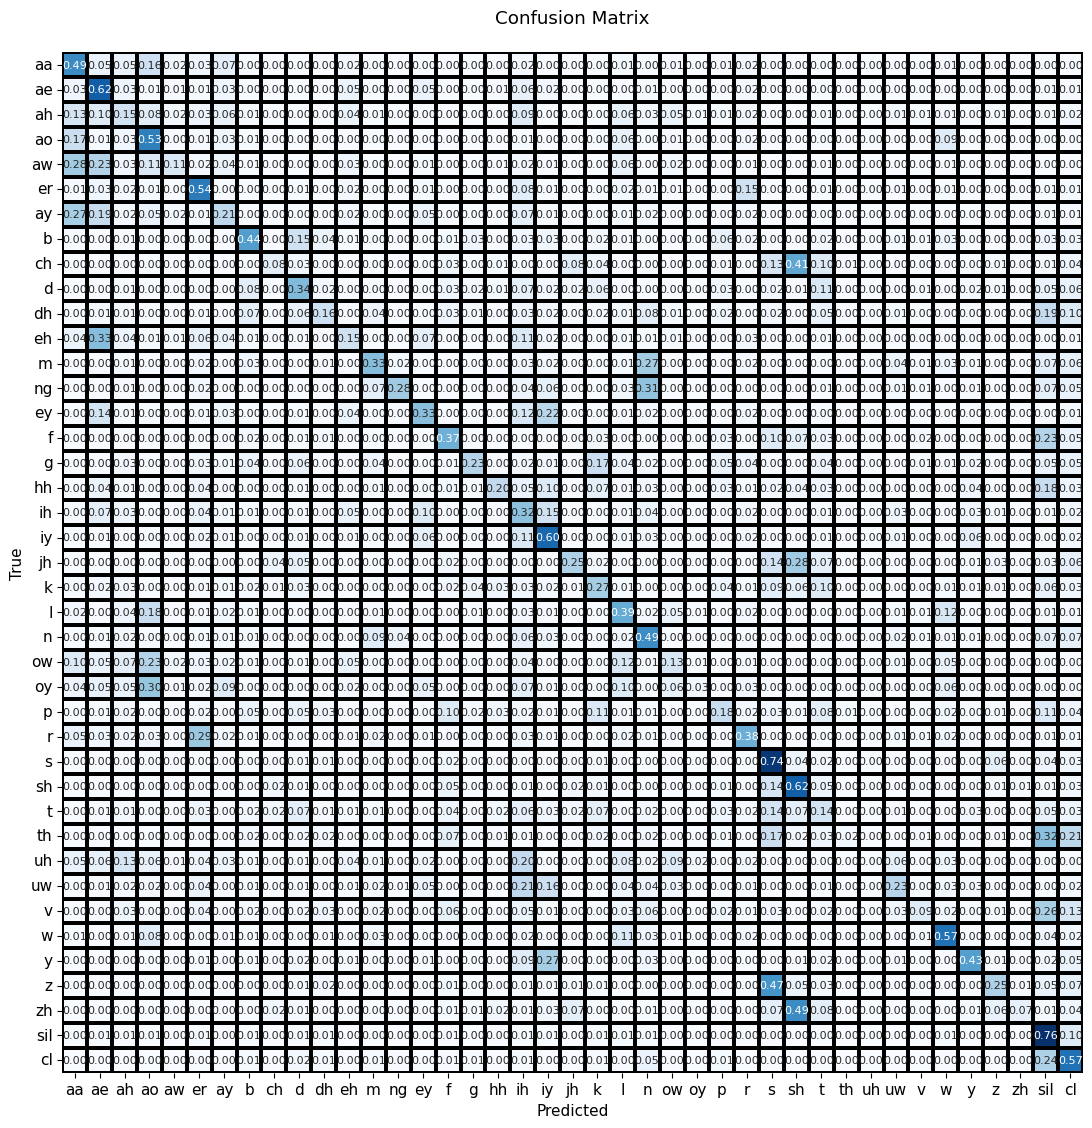

In [33]:
#################
# only modify one of the next four lines to do the requested experiments
feature_selection = slice(0,26)       # use slice(0,13) for selecting MFCC-13 and slice(0,26) for selecting MFCC-13 + Delta's       
n_components = 1                      # default: 8
max_iter = 8                          # default: 8
priors =  'training'                  # default: 'training'  (alternative: 'uniform')
################
X_train_s = X_train[:,feature_selection]
y_train_s = y_train
X_test_s = X_test[:,feature_selection]
y_test_s = y_test
# train the model
clf_GMM,_ = train_GMM(X_train_s, y_train_s,  classes=classes,
                    n_components=n_components, max_iter=max_iter, Verbose=True)
# test the model
acc_test,cm = test_GMM(clf_GMM, X_test_s, y_test_s,  Verbose=True, norm=True, priors=priors)

Test Set:      Accuracy = 52.44%


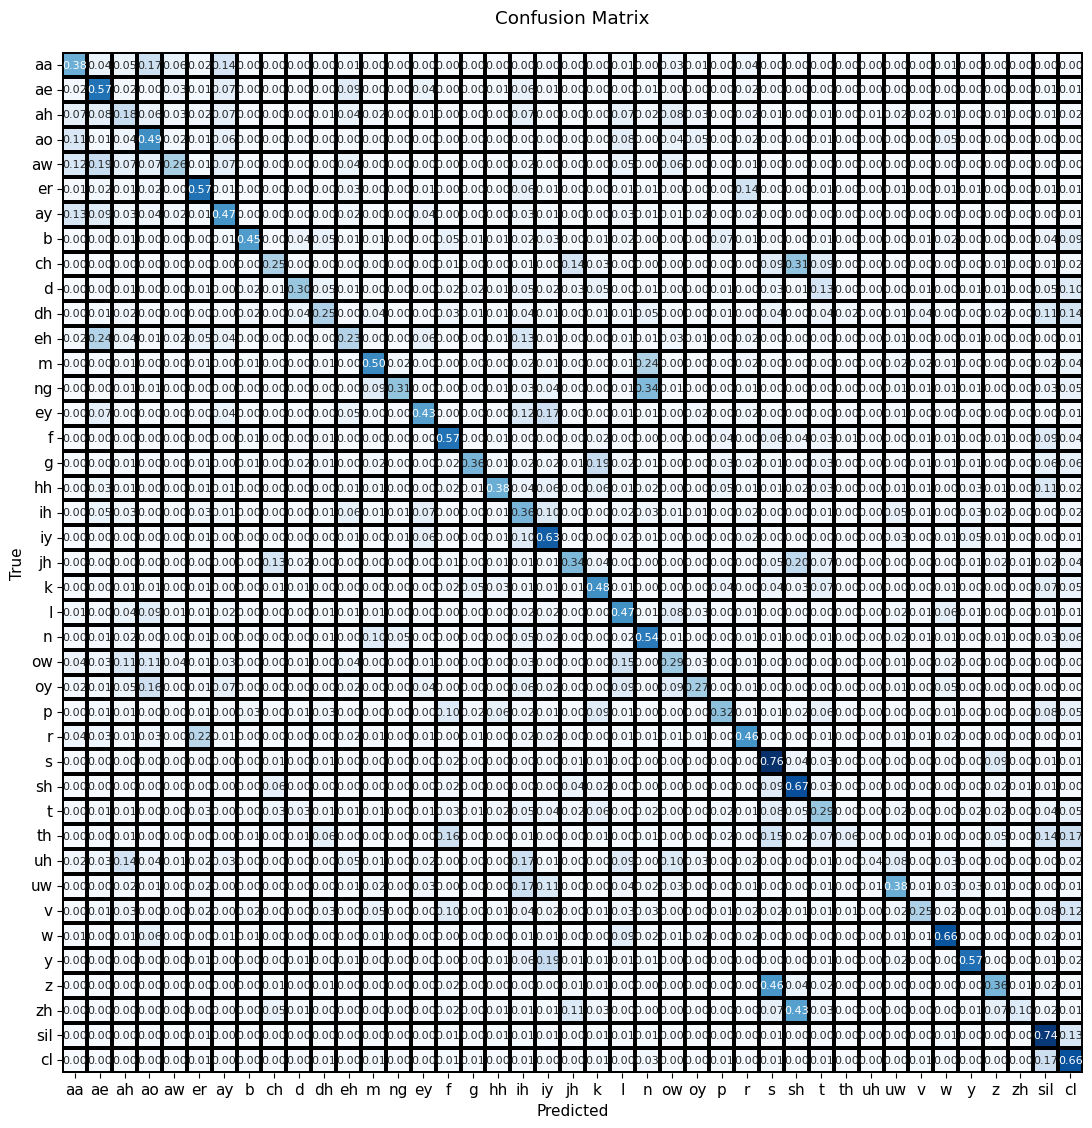

In [31]:
# test the model with different priors
acc_test,cm = test_GMM(clf_GMM, X_test_s, y_test_s, Verbose=True, norm=True, priors='training')
#
#acc_test,cm = test_GMM(clf_GMM, X_test_s, y_test_s,  Verbose=True, norm=True, priors='uniform')

In [ ]:
## save the trained model(s) to disk
## save_pickle(clf_GMM,"GMM_TIMIT_D26_G64.pk")
##
# some results that you might expect to get  (small discrepancies between training and testing)
# TIMIT_MINI_D26  49%
# TIMIT_D26_G8    53%
# TIMIT_D26_G64   56%

## Exercise 3: Using the model in Continuous Speech Recognition

In this part we will use the trained models to compute frame probabilities (likelihoods or posteriors) for an utterance.
Computing these frame probabilities is just a first step towards continuous speech recognition.  
We can evaluate frame recognition rate within a sentence.   
Also we can observe how stable / unstable such observation probabilities are over time.

##### Note on transcriptions and labels
NOTE 1.
One of the labels is 'cl', i.e. closure before a plosive.  These are often present in your transcriptions, e.g.
-  bricks: b r ih cl k s

NOTE 2.
The transcriptions in TIMIT are labels as given by humans listening to very short fragments of an utterance.   Their transcription reflect the sound that they here .  Thus it is NOT a  CANONICAL transcription which is the transcription you find in a dictionary.
As such you may encounter pronunciation variants:
- is: ih s
- is: iy z

##### Questions.
Question 1:
- Select example 2 ("bricks")
- Have a look at the frame probabilites
    + where does the recognizer seems fairly certain
    + assuming  you only have these prob's as your input (i.e. this is what a recognizer gets), what word would you form if you only take into accounts segments of a couple frames that are consistently recognized as the same phone?
    
Question 2:
- Give an example of phonetic confusion that in your opinion will probably not hurt the recognizer when it can use lexical information

In [ ]:
# Import a model or reuse one of the models that you have trained above
#######################################################################
timit_models = "https://homes.esat.kuleuven.be/~spchlab/data/timit/models/gmm/"
# clf_test = get_pickle("GMM_TIMIT_MINI_D26_G8.pk")   # D26 = 26 dim features, G8 = 8 Gaussians, TIMIT_MINI = training database
clf_test = get_pickle(timit_models+"S41_D26_G64_FULL_1.pkl")   # D26 = 26 dim features, G64 = 64 Gaussians, TIMIT = training database
#clf_test = clf_GMM
classes = clf_test.classes
feature_args = feature_args_mfcc13

In [ ]:
# select a test file for analysis
#################################
example = 2
test_files = ['test/dr1/faks0/si2203',  'test/dr8/fcmh1/si1493', 'test/dr4/fadg0/si1279', 'train/dr1/fcjf0/sx307', 'train/dr1/fdaw0/sx236'] #,'train/dr1/fdml0/si1779']
name = test_files[example]
if name == 'test/dr1/faks0/si2203':    # segment selection "for this dive"
    transcrition = "the reasons for this dive are foolish by now"
    segment_transcription = "for this dive"
    phn_sel = np.array(['sil','cl','d','dh','z','s','f','v','r','er','aa','ay','ah','ao','ih']) #'sil','iy','aa','cl'
    frames=[132,209] # [150,250] # #  [160,185]   # [250,350] # 
elif name ==  'test/dr8/fcmh1/si1493':  # segment selection "by that time perhaps something "
    phn_sel = np.array(['sil','cl','b','dh','t','p','s','m','ay','aa','ae','ah','iy','th'])
    phn_sel = np.array(['sil','cl','b','dh','t','p','ay','aa','ae','ah','eh'])
    frames=[10,65]
elif name == 'test/dr4/fadg0/si1279':  # bricks are an alternative
    transcription = "bricks are an alternative"
    segment_transcription = "bricks"
    phn_sel = np.array(['sil','b','r','ih','cl','k','s','dh','t','iy','ae','eh','ey','z'])
    frames = [10,50]
elif name == 'train/dr1/fcjf0/sx307': # the meeting is now adjourned
    transcription = "the meeting is now adjourned"
    segment_transcription = "the meeting is now"
    phn_sel = np.array(['sil','ih','iy','ey','aw','ay','dh','t','s','f','z','ng','n','m']) 
    frames = [5,80]
elif name == 'train/dr1/fdaw0/sx236': # clear pronunciation is appreciated
    transcription = "clear pronunciation is appreciated"
    segment_transcription = "is appreciated"
    phn_sel = np.array(['sil','cl','ah','aw','ae','eh','ey','ih','iy','uh','b','d','dh','p','t','k','r','l','s','sh','ng','n','m'])
    frames = [160,250]
else:
    phn_sel = phnset
    frames = [0,-1]
#
shift = 0.01
indx_sel = [classes.index(phn) for phn in phn_sel]
frame_sel = slice(frames[0],frames[1])
x0 = (frames[0]+.5)*shift

# audio and feature extraction
example_audio, sample_rate = pyspch.audio.load(timit_root + 'audio/' + name + ".wav")
example_spg = pyspch.sp.feature_extraction(example_audio, sample_rate=sample_rate) #, **setup.feature_args)
example_features = pyspch.sp.feature_extraction(example_audio, **feature_args)
# transcription + word segmentation 
# transcription + word segmentation 
example_txt = pyspch.read_txt(timit_root + 'segmentation/' + name + ".txt")
example_wrd = pyspch.timit.read_seg_file(timit_root + 'segmentation/' + name + ".wrd", dt=1/sample_rate)
print(example_txt)    
# get reference segmentation and labels , phone segmentation (+ as index)
example_phn = pyspch.timit.read_seg_file(timit_root + 'segmentation/' + name + ".phn", fmt="float32", dt=1/sample_rate,xlat='timit61_timit41')
example_lab = pyspch.seg2lbls(example_phn, n_frames=example_features.shape[1],pad_lbl='sil') 

In [ ]:
#  SHOW THE EXAMPLE: waveform, spectrogram, features, reference transcription and segmentation
#################################
fig = pyspch.display.PlotSpgFtrs(wavdata=example_audio, spgdata=example_spg,dy=1,
                            frames=frames, sample_rate=sample_rate, figsize=(15,6), img_ftrs=[example_features])
fig.add_seg_plot(example_phn, iax=1, ypos=.15, color='k') 
fig.add_seg_plot(example_wrd, iax=0, ypos=.9, color='r') # seg
display(fig)
display(Audio(data=example_audio,rate=sample_rate))

In [ ]:
# compute frame posterior probabilities and do frame by frame recognition, compute the frame error rate in the sentence
##########################################################################
postprob_gmm = clf_test.predict_proba(X=example_features.T)
# evaluate frame based recognition wrt. manual segmentations
y_gmm_idx = np.argmax(postprob_gmm, axis=1)
y_gmm_lab = [classes[i] for i in y_gmm_idx]
# alternative
# y_gmm_lab = clf_GMM.predict(X=example_features.T)
y_gmm_seg = pyspch.lbls2seg(y_gmm_lab)
n_corr = np.sum([y_gmm_lab[i] == example_lab[i] for i in range(len(example_lab))])
print("Frame Recognition Rate (for full utterance): %.2f %%" % (100.*n_corr/len(example_lab)))

In [ ]:
# plot frame posterior probs and phones for a short segment and a selection of phones
######################################################################################
fig = pyspch.display.PlotSpgFtrs(wavdata=example_audio, spgdata=example_spg,dy=1,row_heights=[1.5,2,4,4,.75],
                                 frames=frames, sample_rate=sample_rate, figsize=(15,10), img_ftrs=[None,None])
fig.add_seg_plot(example_phn, iax=1, ypos=.85, color='k') # seg
fig.add_seg_plot(example_wrd, iax=0, ypos=.9, Lines=True, color='r')

#plot_probs(prob_dnn_sel, phn_sel,fig=fig, iax=0, x0=frames[0]*.01, style="line", title="DNN Posterior Probs") # probs
plot_probs(postprob_gmm[frame_sel,indx_sel], phn_sel,fig=fig, iax=2, x0=frames[0]*.01, style="img", title="GMM Posterior Probs")
plot_probs(postprob_gmm[frame_sel,indx_sel], phn_sel,fig=fig, iax=3, x0=frames[0]*.01, style="line", title="GMM Posterior Probs")

fig.add_seg_plot(y_gmm_seg, iax=4, ypos=.25, Lines=True, color='k') # predicted labels
fig

In [ ]:
# Other Utilities 

        
# utilities for saving and retrieving models from pickle files
def save_pickle(data,filename):
    picklefile = open(filename, 'wb')
    pickle.dump(data, picklefile),
    picklefile.close()    
def get_pickle(filename):
    picklefile = pyspch.read_fobj(filename)    
    data = pickle.load(picklefile)
    picklefile.close()
    return(data)

# plot utilities
def plot_probs(probs, labels,  fig, iax=2, x0=0.,vmin=None, title="", style="line"):
    '''
    Utility to add selected phone predictors/posteriors ...  to an axis in line or img view 
    '''
    ax = fig.axes[iax]
    # find selected indices from phone labels
    #indx_sel = [labels.index(phn) for phn in selection]
    #probs = probs[:,indx_sel]
    
    ## 
    if style =="img":
        sns.heatmap(probs.T, ax=ax, yticklabels=labels, cmap=cmap_jet2,vmin=vmin,linewidths=1,linecolor='k',cbar_kws={'pad':0.0})
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        ax.set_xticks([])
    elif style == "line":
        fig.add_line_plot(probs.T, iax=iax, x0=x0, dx=.01, yrange=[0.,1.],color=None)   # defaults to blue for all lines if not specified
        fig.axes[iax].legend(labels, loc='center right', fontsize='x-small') # bbox_to_anchor=(1.00,.5))  # , ncol=15)
    ax.set_title(title)